# Importing packages

In [1]:
import tensorflow as tf
import datetime
import os
import numpy as np
import pathlib
import pandas as pd
import requests
from io import BytesIO
import statistics
import random
from platform import platform
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import InputLayer, Softmax, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation


In [ ]:
!pip install tensorflow==2.9

In [ ]:
def print_system_info():
    print(f"nTF:     {tf.__version__}\nKeras:  {tf.keras.__version__}"
          f"\nCUDA:   {tf.sysconfig.get_build_info()['cuda_version']}\ncuDNN:  {tf.sysconfig.get_build_info()['cudnn_version']}")
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\nGPUs:   {len(gpus) if gpus else 'No GPU available. Running on CPU.'}")
print_system_info()

nTF:     2.9.0
Keras:  2.9.0
CUDA:   11.2
cuDNN:  8

GPUs:   1


# Prepearing data

In [2]:
main_path = 'drive/Othercomputers/MacBook/Projekt_DL/dane'

In [3]:
train = os.path.join(main_path,'train')
test = os.path.join(main_path,'test')
valid = os.path.join(main_path,'valid')

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train,
    labels='inferred',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

test_data = tf.keras.utils.image_dataset_from_directory(
    test,
    labels='inferred',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

val_data = tf.keras.utils.image_dataset_from_directory(
    valid,
    labels='inferred',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

class_names = train_data.class_names
print(class_names)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'A

# Data visualisation - random pictures

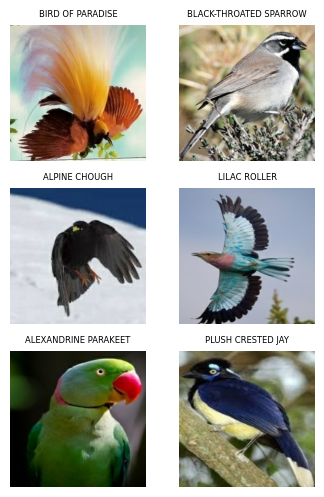

In [274]:
plt.figure(figsize=(4, 6))
for images, labels in train_data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]],fontsize=6)
    plt.axis("off")

# Augumentacja

In [264]:
def data_augmentor(h_flip=True, v_flip=False, rotate=True,):

    augmentor = Sequential() # Create returned Sequential class.
    augmentor.add(layers.Rescaling(1./255)) # Rescale image values from 0 - 255 to 0 - 1.

    # Based on function arguments: perform random flipping
    if h_flip and v_flip:
      augmentor.add(layers.RandomFlip('horizontal_and_vertical'))

    # Based on function arguments: perform random rotation
    if rotate:
        augmentor.add(layers.RandomRotation(0.2))

    return augmentor

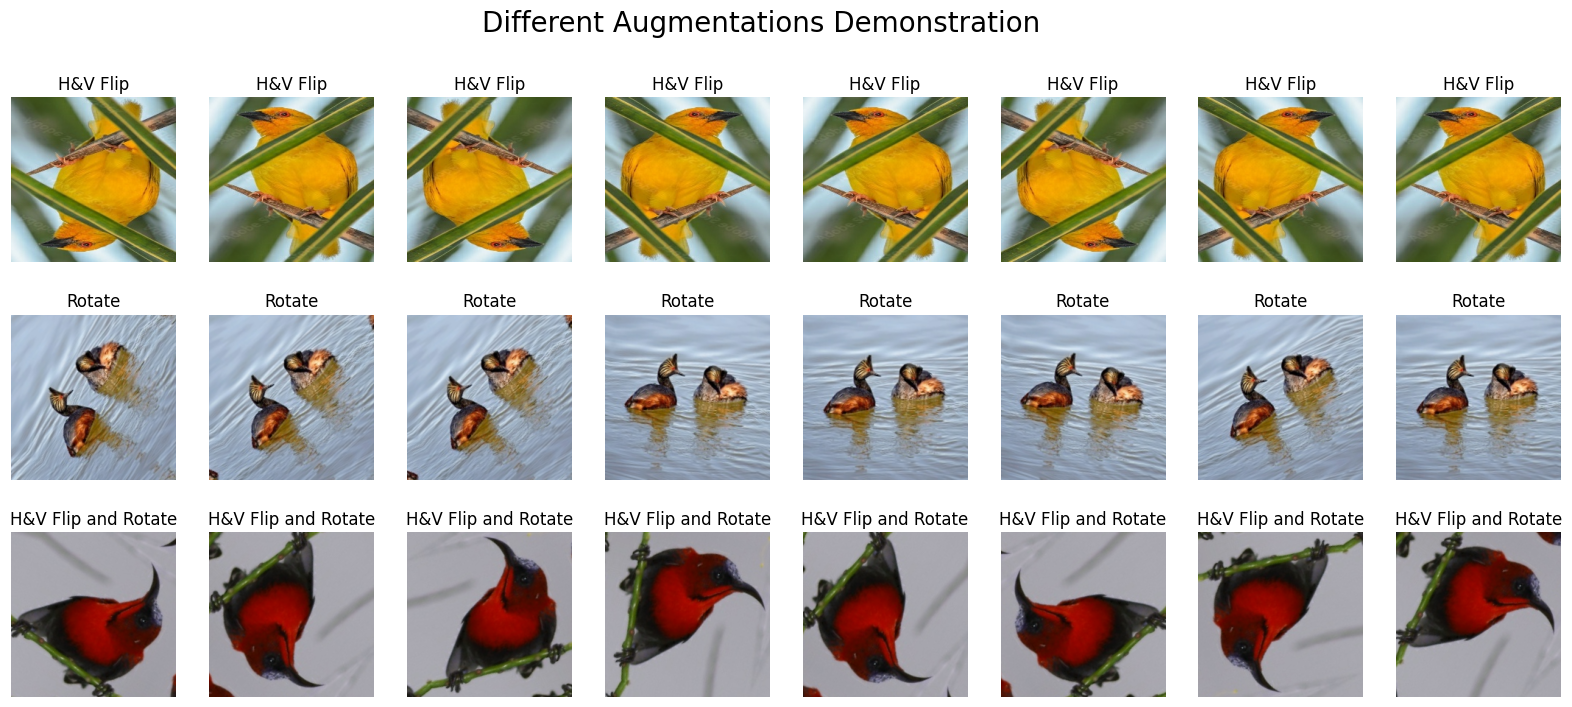

In [288]:
augmentor1 = data_augmentor(h_flip = True, v_flip = True, rotate=False)
augmentor2 = data_augmentor(h_flip = False, v_flip = False, rotate=True)
augmentor3 = data_augmentor(h_flip = True, v_flip = True, rotate=True)


augs = [augmentor1, augmentor2, augmentor3]

details = ['H&V Flip',
           'Rotate',
           'H&V Flip and Rotate']

plt.figure(figsize=(20, 8))
for images, labels in train_data .take(1):
    for i, aug in enumerate(augs):
        img = images[i]
        for j in range(8):
            ax = plt.subplot(3, 8, (i*8 + j + 1))
            img_augmented = aug(tf.expand_dims(img, 0))
            plt.imshow(img_augmented[0])
            plt.axis('off')
            ax.set_title(details[i])

plt.suptitle('Different Augmentations Demonstration', fontsize=20);

# EfficientNetB2 z augumentacja

In [ ]:
efnet_B2_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='max',
                    classes=525,
                    classifier_activation='softmax')

efnet_B2_model.trainable = False

35839040/35839040 [==============================] - 1s 0us/step


In [ ]:
model_efb2a = Sequential()
model_efb2a.add(InputLayer(input_shape=(224, 224, 3)))
model_efb2a.add(RandomFlip("horizontal_and_vertical"))
model_efb2a.add(RandomRotation(0.2))
model_efb2a.add(efnet_B2_model)
model_efb2a.add(Dropout(0.2))
model_efb2a.add(Dense(525,activation='softmax'))

model_efb2a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 525)               739725    
                                                                 
Total params: 9,509,099
Trainable params: 739,725
Non-

In [ ]:
model_efb2a.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [ ]:
# callback early stopping
# zatrzymanie treningu w momencie, kiedy val_loss nie spada przez n epok
es_efs2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5
)

modelcheck_lr_s2 = tf.keras.callbacks.ModelCheckpoint(filepath= 'drive/Othercomputers/MacBook/Projekt_DL/dane/model_efnB2_pre_a.h5'
 ,monitor='val_loss', save_best_only = True, save_format='tf')

In [ ]:
model_hist_efsB2 = model_efb2a.fit(train_data, validation_data = val_data, epochs = 15, callbacks = [ es_efs2, modelcheck_lr_s2])

Epoch 1/15
2645/2645 [==============================] - 5112s 2s/step - loss: 4.7153 - accuracy: 0.4175 - val_loss: 1.2823 - val_accuracy: 0.7806
Epoch 2/15
2645/2645 [==============================] - 241s 91ms/step - loss: 3.3224 - accuracy: 0.6112 - val_loss: 0.8746 - val_accuracy: 0.8461
Epoch 3/15
2645/2645 [==============================] - 239s 90ms/step - loss: 3.1649 - accuracy: 0.6595 - val_loss: 0.9920 - val_accuracy: 0.8522
Epoch 4/15
2645/2645 [==============================] - 241s 91ms/step - loss: 3.1248 - accuracy: 0.6860 - val_loss: 0.9934 - val_accuracy: 0.8747
Epoch 5/15
2645/2645 [==============================] - 239s 90ms/step - loss: 3.0368 - accuracy: 0.7086 - val_loss: 0.9249 - val_accuracy: 0.8785
Epoch 6/15
2645/2645 [==============================] - 240s 91ms/step - loss: 3.1094 - accuracy: 0.7181 - val_loss: 0.8021 - val_accuracy: 0.8903
Epoch 7/15
2645/2645 [==============================] - 239s 90ms/step - loss: 3.0493 - accuracy: 0.7323 - val_loss: 0.

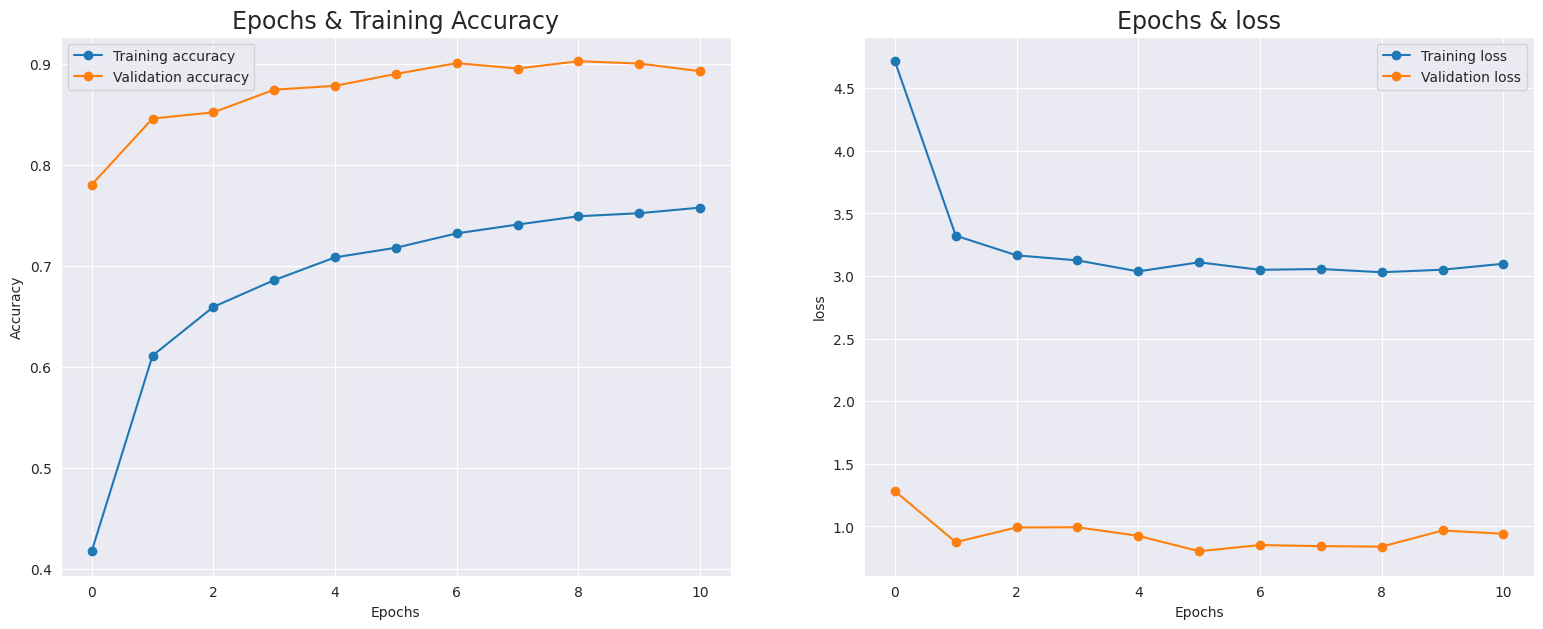

In [ ]:
#Visualizing the result
acc = model_hist_efsB2.history['accuracy']
val_acc = model_hist_efsB2.history['val_accuracy']
loss = model_hist_efsB2.history['loss']
val_loss = model_hist_efsB2.history['val_loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].plot(val_loss, 'o-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

In [ ]:
# setting all the layers of this model to True - start training
efnet_B2_model.trainable = True

model_efb2a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 525)               739725    
                                                                 
Total params: 9,509,099
Trainable params: 9,426,811
No

In [ ]:
model_efb2a.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [ ]:
model_hist_efsB2 = model_efb2a.fit(train_data, validation_data = val_data, epochs = 10, callbacks = [ es_efs2, modelcheck_lr_s2])

Epoch 1/10
2645/2645 [==============================] - 695s 263ms/step - loss: 0.3837 - accuracy: 0.9079 - val_loss: 0.1774 - val_accuracy: 0.9573
Epoch 2/10
2645/2645 [==============================] - 695s 263ms/step - loss: 0.3358 - accuracy: 0.9159 - val_loss: 0.1670 - val_accuracy: 0.9558
Epoch 3/10
2645/2645 [==============================] - 695s 263ms/step - loss: 0.3054 - accuracy: 0.9220 - val_loss: 0.1556 - val_accuracy: 0.9550
Epoch 4/10
2645/2645 [==============================] - 694s 262ms/step - loss: 0.2837 - accuracy: 0.9264 - val_loss: 0.1446 - val_accuracy: 0.9608
Epoch 5/10
2645/2645 [==============================] - 694s 262ms/step - loss: 0.2551 - accuracy: 0.9325 - val_loss: 0.1354 - val_accuracy: 0.9646
Epoch 6/10
2645/2645 [==============================] - 694s 262ms/step - loss: 0.2367 - accuracy: 0.9368 - val_loss: 0.1339 - val_accuracy: 0.9650
Epoch 7/10
2645/2645 [==============================] - 696s 263ms/step - loss: 0.2198 - accuracy: 0.9402 - val_

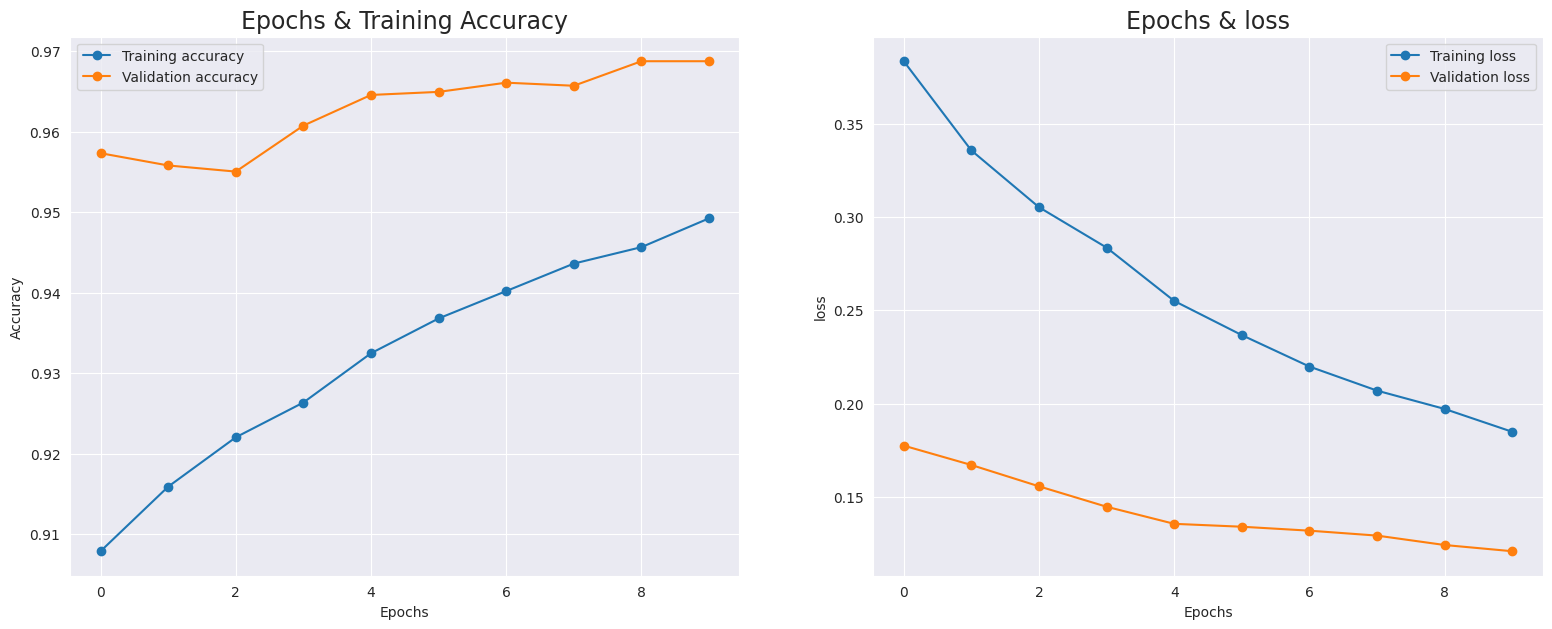

In [ ]:
#Visualizing the result
acc = model_hist_efsB2.history['accuracy']
val_acc = model_hist_efsB2.history['val_accuracy']
loss = model_hist_efsB2.history['loss']
val_loss = model_hist_efsB2.history['val_loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].plot(val_loss, 'o-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# CNN nowa wersja

In [ ]:
# data augumentaition - applied in the model as layers

num_classes = 525

model_cna = Sequential()
model_cna.add(InputLayer(input_shape=(224, 224, 3)))
model_cna.add(Rescaling(1./255))
model_cna.add(RandomFlip("horizontal_and_vertical"))
model_cna.add(RandomRotation(0.2))
model_cna.add(Conv2D(32, 3, activation='relu'))
model_cna.add(Conv2D(64, 3, activation='relu'))
model_cna.add(MaxPooling2D((2,2)))
model_cna.add(Dropout(0.2))
model_cna.add(Conv2D(64, 3, activation='relu'))
model_cna.add(Conv2D(128, 3, activation='relu'))
model_cna.add(MaxPooling2D((2,2)))
model_cna.add(Dropout(0.2))
model_cna.add(Conv2D(128, 3, activation='relu'))
model_cna.add(Conv2D(64, 3, activation='relu'))
model_cna.add(MaxPooling2D((2,2)))
model_cna.add(Dropout(0.2))
model_cna.add(Conv2D(64, 3, activation='relu'))
model_cna.add(Conv2D(32, 3, activation='relu'))
model_cna.add(MaxPooling2D((2,2)))
model_cna.add(Conv2D(32, 1, activation='relu'))
model_cna.add(MaxPooling2D((2,2)))
model_cna.add(Dropout(0.2))
model_cna.add(Flatten())
model_cna.add(Dense(128, activation='relu'))
model_cna.add(Dense(num_classes, activation='softmax'))

model_cna.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 conv2d_53 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_54 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                 

In [ ]:
model_cna.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [ ]:
# callback early stopping
# zatrzymanie treningu w momencie, kiedy val_loss nie spada przez n epok
es_cna = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5
    )

modelcheck_lr_a = tf.keras.callbacks.ModelCheckpoint(filepath= 'drive/Othercomputers/MacBook/Projekt_DL/dane/model_CNN_kaggle_new.h5'
 ,monitor='val_loss', save_best_only = True, save_format='tf')

In [ ]:
model_hist_cna = model_cna.fit(train_data, validation_data = val_data, epochs = 60, callbacks = [es_cna, modelcheck_lr_a])

Epoch 1/60
2645/2645 [==============================] - 675s 254ms/step - loss: 5.9986 - accuracy: 0.0070 - val_loss: 5.5408 - val_accuracy: 0.0225
Epoch 2/60
2645/2645 [==============================] - 660s 249ms/step - loss: 5.4294 - accuracy: 0.0253 - val_loss: 5.0253 - val_accuracy: 0.0522
Epoch 3/60
2645/2645 [==============================] - 659s 249ms/step - loss: 4.9689 - accuracy: 0.0549 - val_loss: 4.7001 - val_accuracy: 0.0796
Epoch 4/60
2645/2645 [==============================] - 658s 249ms/step - loss: 4.5898 - accuracy: 0.0863 - val_loss: 4.2670 - val_accuracy: 0.1257
Epoch 5/60
2645/2645 [==============================] - 659s 249ms/step - loss: 4.3375 - accuracy: 0.1151 - val_loss: 4.1904 - val_accuracy: 0.1440
Epoch 6/60
2645/2645 [==============================] - 659s 249ms/step - loss: 4.1342 - accuracy: 0.1418 - val_loss: 3.8796 - val_accuracy: 0.1821
Epoch 7/60
2645/2645 [==============================] - 659s 249ms/step - loss: 3.9623 - accuracy: 0.1687 - val_

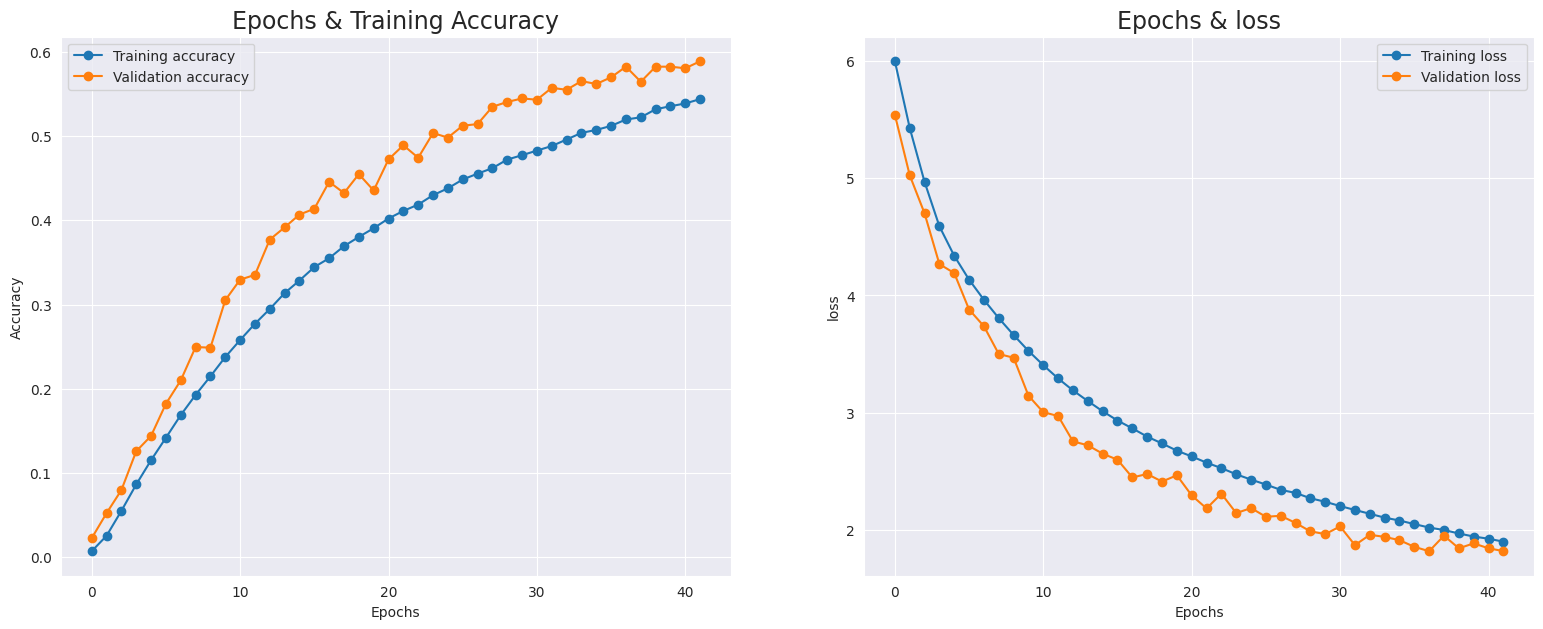

In [ ]:
#Visualizing the result
acc = model_hist_cna.history['accuracy']
val_acc = model_hist_cna.history['val_accuracy']
loss = model_hist_cna.history['loss']
val_loss = model_hist_cna.history['val_loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].plot(val_loss, 'o-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# CNN nowe parametry - sprawdzenie czy beda lepsze wyniki

In [ ]:
# data augumentaition - applied in the model as layers

num_classes = 525

model_cna2 = Sequential()
model_cna2.add(InputLayer(input_shape=(224, 224, 3)))
model_cna2.add(Rescaling(1./255))
model_cna2.add(RandomFlip("horizontal_and_vertical"))
model_cna2.add(RandomRotation(0.2))
model_cna2.add(Conv2D(18, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Conv2D(32, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Conv2D(64, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Conv2D(128, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Conv2D(256, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Conv2D(128, 3, activation='relu'))
model_cna2.add(MaxPooling2D((2,2)))
model_cna2.add(Dropout(0.2))
model_cna2.add(Flatten())
model_cna2.add(Dense(256, activation='relu'))
model_cna2.add(Dropout(0.2))
model_cna2.add(Dense(num_classes, activation='softmax'))

model_cna2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 18)      504       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 18)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 18)      0

In [ ]:
model_cna2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [ ]:
# callback early stopping
# zatrzymanie treningu w momencie, kiedy val_loss nie spada przez n epok
es_cna2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5
    )

modelcheck_lr_a2 = tf.keras.callbacks.ModelCheckpoint(filepath= 'drive/Othercomputers/MacBook/Projekt_DL/dane/model_CNN_kaggle_v2.h5'
 ,monitor='val_loss', save_best_only = True, save_format='tf')

In [ ]:
model_hist_cna2 = model_cna2.fit(train_data, validation_data = val_data, epochs = 90, callbacks = [es_cna2, modelcheck_lr_a2])

Epoch 1/90
2645/2645 [==============================] - 135s 51ms/step - loss: 2.0678 - accuracy: 0.4928 - val_loss: 2.0161 - val_accuracy: 0.5352
Epoch 2/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0644 - accuracy: 0.4959 - val_loss: 1.8948 - val_accuracy: 0.5592
Epoch 3/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0585 - accuracy: 0.4972 - val_loss: 1.8652 - val_accuracy: 0.5539
Epoch 4/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0544 - accuracy: 0.4970 - val_loss: 1.9736 - val_accuracy: 0.5402
Epoch 5/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0453 - accuracy: 0.4967 - val_loss: 1.8501 - val_accuracy: 0.5646
Epoch 6/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0377 - accuracy: 0.5012 - val_loss: 1.9714 - val_accuracy: 0.5394
Epoch 7/90
2645/2645 [==============================] - 136s 51ms/step - loss: 2.0295 - accuracy: 0.4999 - val_loss: 1

In [ ]:
#Visualizing the result
acc = model_hist_cna2.history['accuracy']
val_acc = model_hist_cna2.history['val_accuracy']
loss = model_hist_cna2.history['loss']
val_loss = model_hist_cna2.history['val_loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].plot(val_acc, 'o-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].plot(val_loss, 'o-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

# Predykcja EfficientNetB2

In [7]:
model = tf.keras.models.load_model(os.path.join(main_path,"model_efnB2_pre_a.h5"))

In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, save_img
from PIL import Image
import numpy as np



img_array /= 255.
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"The image is predicted to be of class: {predicted_class}")

1/1 [==============================] - 0s 30ms/step
The image is predicted to be of class: 466


In [56]:
img = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/ANNAS HUMMINGBIRD/002.jpeg')
size = (224, 224)

img_resized = smart_resize(img, size)

img_array = img_to_array(img_resized)

In [67]:
#print(img_resized)

save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/ANNAS HUMMINGBIRD/001t.jpg', img_resized)

In [ ]:
img2 = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/ANNAS HUMMINGBIRD/001.jpeg')
img2_resized = smart_resize(img2, size)
save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/ANNAS HUMMINGBIRD/002t.jpg', img2_resized)

In [70]:
img3 = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/BLACK VULTURE/001.jpeg')
img3_resized = smart_resize(img3, size)
save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/BLACK VULTURE/001t.jpg', img3_resized)

In [74]:
img4 = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/BLACK VULTURE/002.jpeg')
img4_resized = smart_resize(img4, size)
save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/BLACK VULTURE/002t.jpg', img4_resized)

In [75]:
img5 = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/EASTERN BLUEBIRD/001.jpeg')
img5_resized = smart_resize(img5, size)
save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/EASTERN BLUEBIRD/001t.jpg', img5_resized)

In [76]:
img6 = load_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/EASTERN BLUEBIRD/002.jpeg')
img6_resized = smart_resize(img6, size)
save_img('drive/Othercomputers/MacBook/Projekt_DL/dane/out/EASTERN BLUEBIRD/002t.jpg', img6_resized)

In [ ]:
y_pred_label = []  # store predicted labels
y_true_label = []  # store true labels
y_true_img = [] # store true images

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true_label.append(label_batch)
   y_true_img.append(image_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred_label.append(np.argmax(preds, axis = - 1))


AMERICAN REDSTART
AMERICAN REDSTART
tf.Tensor(22, shape=(), dtype=int32)


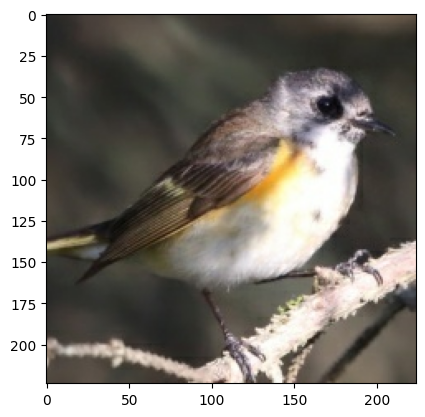

In [172]:
class_list =list(class_names)
i = 6
j = 7

tl = y_true_label[i][j]
pl = y_pred_label[i][j]
print(class_list[tl])
print(class_list[pl])
print(tl)
plt.imshow(y_true_img[i][j].numpy().astype("int"))

In [168]:
# pictures from internet - testing
out = os.path.join(main_path,'out')

In [236]:
out_data = tf.keras.utils.image_dataset_from_directory(
    out,
    labels='inferred',
    color_mode='rgb',
    batch_size=1,
    image_size=(224, 224),
    shuffle=False,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

Found 7 files belonging to 3 classes.


In [237]:
y_true_out_label = [] # store true labels
y_pred_out_label = []  # store predicted labels
y_true_out_img = [] # store true images

# iterate over the dataset
for image_batch, label_batch in out_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true_out_img.append(image_batch)
   y_true_out_label.append(label_batch)
   # compute predictions
   preds_o = model.predict(image_batch)
   # append predicted labels
   y_pred_out_label.append(np.argmax(preds_o, axis = - 1))


1/1 [==============================] - 0s 28ms/step


In [238]:
y_pred_out_label

[array([31]),
 array([31]),
 array([332]),
 array([88]),
 array([88]),
 array([198]),
 array([198])]

Predicted_class_nr:   [332]
Predicted_class_name: LOONEY BIRDS
Katalog_name:         ANNAS HUMMINGBIRD


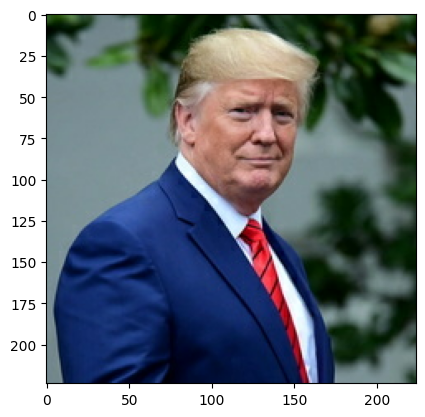

In [247]:
class_list =list(class_names) # model class_names
out_class_list = list(out_data.class_names) # class names from outer data set

p = 2 #there is 6 pictures p must be between 0 and 5
img = np.reshape(y_true_out_img[p],(224,224,3)) #images must be reshaped
predict_out_label = int(y_pred_out_label[p])
print(f'Predicted_class_nr:  ',y_pred_out_label[p])
print(f'Predicted_class_name:',class_list[predict_out_label])

true_out_label = int(y_true_out_label[p])
print(f'Katalog_name:        ',out_class_list[true_out_label])

plt.imshow(img.astype('uint8'))

1/1 [==============================] - 0s 38ms/step


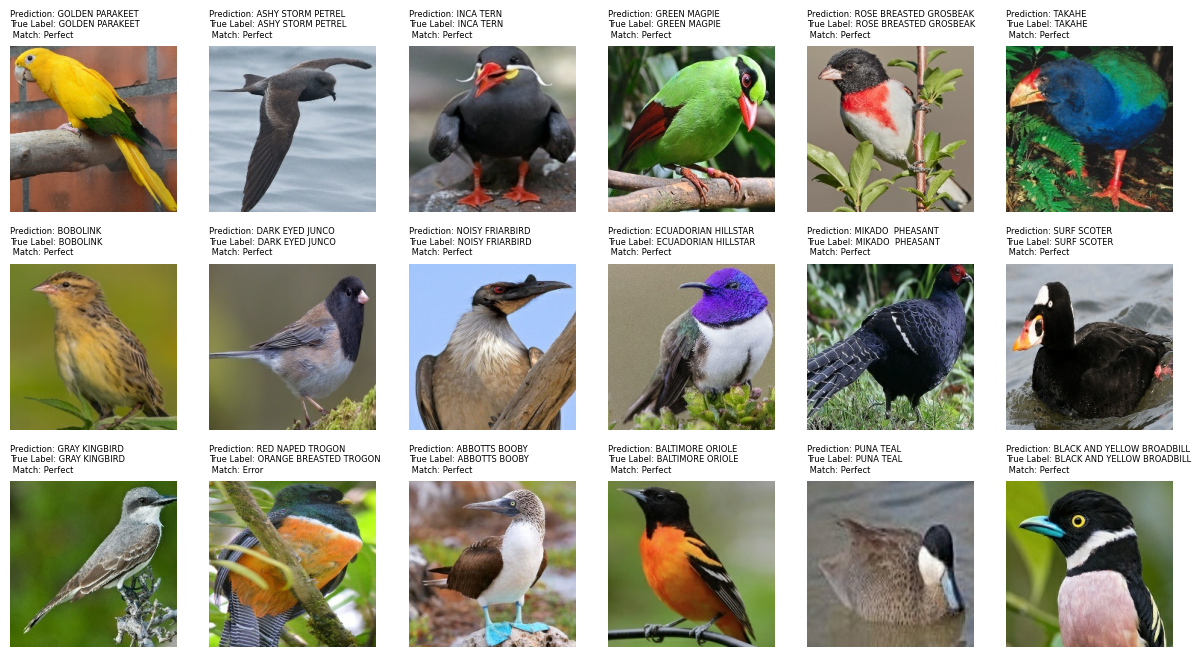

In [311]:
test_labels = test_data.class_names

plt.figure(figsize=(15, 8))

for image, label in test_data.take(1):
    model_prediction = model.predict(image)
    for i in range(18):
        plt.subplot(3, 6, i+1)
        plt.imshow(image[i].numpy().astype("int"))
        p = test_labels[tf.argmax(tf.round(model_prediction[i]))]
        t = test_labels[(label[i])]
        if p == t:
          m = "Perfect"
        else:
          m = "Error"
        plt.title(f"Prediction: {p}\nTrue Label: {t}\n Match: {m}", fontsize=6, loc='left')
        plt.grid(False)
        plt.axis("off")
    plt.show()